# AAVAIL Exploratory Data Analysis

### Dataset

To sum up, AAVAIL managers have asked to build a service that, at any point in time, will predict the revenue for the following month, in general or for specific countries. To keep the development time reasonable the model should be limited to the ten countries with the most revenue.

The available data is stored in a set of several json files which represents a monthly data of AAVAIL's transaction for different countries. 

### Attribute Information:

The features found in the data are: 

- country
- customer_id
- day
- invoice
- month
- stream_id
- times_viewed
- total_price
- year

### Testable hypotheses.

Some testable hypotheses could be:

- Does the new model perform better than the managers' custom methods, i.e. does it achieve a lower Mean Absolute Error (MAE), given the training set and test set provided by the company? 

- Is the MAE difference significant?

- Does customers' behavior vary across countries, i.e. in terms of revenue?


In [1]:
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import norm

In [2]:
%matplotlib inline

### Data Ingestion

In [3]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
        
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

In [33]:
# Function to Detection Outlier on one-dimentional datasets.
anomalies=[]
def find_anomalies(data):
    anomalies.clear()
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 3
    
    lower_limit = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

In [4]:
df_total = pd.DataFrame()

data_dir = os.path.join("..","data","cs-train")

df_total = fetch_data(data_dir)

print(df_total.shape)


(815011, 10)


In [5]:

df_total.head(10)

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28
5,United Kingdom,13085.0,28,489434,11,1.25,21871,14,2017,2017-11-28
6,United Kingdom,13085.0,28,489434,11,5.95,21523,10,2017,2017-11-28
7,United Kingdom,13085.0,28,489435,11,2.55,22350,12,2017,2017-11-28
8,United Kingdom,13085.0,28,489435,11,3.75,22349,12,2017,2017-11-28
9,United Kingdom,13085.0,28,489435,11,1.65,22195,18,2017,2017-11-28


In [6]:
print("Number of different countries contained in the dataset")
len(set(df_total['country']))

Number of different countries contained in the dataset


43

In [7]:
print("Number of different days covered by the dataset")
len(set(df_total['invoice_date']))

Number of different days covered by the dataset


495

In [8]:
df_total.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


# Exploratory Data Analysis

### Dataset Info

Checking Infomation about Dataset Columns including its datatypes and missing data

In [9]:
df_total.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 62.2+ MB


### Missing Data

In [10]:
df_total.isna().sum()

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64

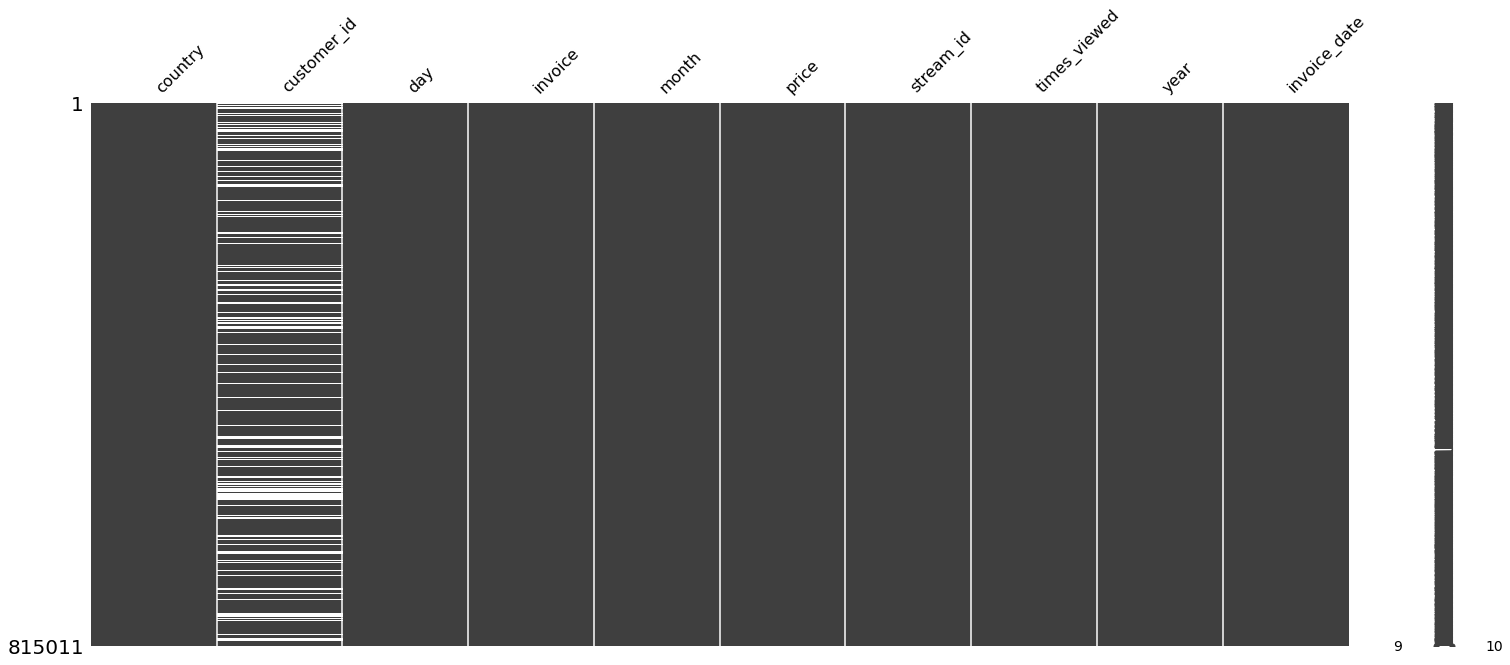

In [11]:
msno.matrix(df_total)
plt.show()

In [12]:
def missing_zero_values_table(df):

    zero_val = (df == 0.00).astype(int).sum(axis=0)
    
    mis_val = df.isnull().sum()
    
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[mz_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n" 
    "There are " + str(mz_table.shape[0]) +
    " columns that have missing values.")
    
    return mz_table

In [13]:
missing_zero_values_table(df_total)

Your selected dataframe has 10 columns and 815011 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
customer_id,0,189762,23.3,189762,23.3,float64


### Removing Alphanumeric Characters from Invoice Column

In [14]:
def removeAlphanumeric(InputString):
    return re.sub(r'[^0-9]', '', InputString)

In [15]:
df_total['invoice'] = df_total['invoice'].apply(removeAlphanumeric)

### Removing Lines where Price < 0

In [16]:
# See if price is negative. If yes, remove
df_total[df_total['price'] < 0]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
180418,United Kingdom,NaN,26,506401,4,-53594.36,B,1,2018,2018-04-26
276274,United Kingdom,NaN,16,516228,7,-44031.79,B,1,2018,2018-07-16
403469,United Kingdom,NaN,17,528059,10,-38925.87,B,1,2018,2018-10-17


In [17]:
df_total = df_total[df_total['price'] >= 0]
df_total.shape

(815008, 10)

### Countries with Higher Revenues

In [18]:
print("Countries With Most Entries")
df_total['country'].value_counts()

Countries With Most Entries


United Kingdom          751225
EIRE                     13577
Germany                  13336
France                    9899
Netherlands               4024
Spain                     2606
Switzerland               2326
Belgium                   2166
Portugal                  1815
Australia                 1543
Channel Islands           1287
Sweden                    1156
Italy                     1049
Cyprus                     907
Norway                     796
Finland                    749
Austria                    719
Denmark                    629
Greece                     627
Unspecified                614
Japan                      514
United Arab Emirates       462
Poland                     429
Singapore                  310
Hong Kong                  276
USA                        266
Canada                     223
Malta                      219
Iceland                    195
Lithuania                  189
Israel                     139
Bahrain                    126
RSA     

In [34]:
find_anomalies(df_total.price)

[647.19,
 470.24,
 775.24,
 862.67,
 1998.49,
 922.05,
 862.38,
 630.36,
 560.87,
 483.14,
 660.21,
 810.57,
 1213.02,
 815.01,
 882.72,
 602.14,
 632.06,
 398.05,
 848.43,
 906.26,
 500.13,
 637.09,
 945.56,
 753.98,
 803.25,
 803.25,
 692.24,
 604.12,
 547.3,
 440.9,
 467.05,
 429.14,
 780.52,
 780.52,
 780.52,
 371.77,
 975.11,
 435.88,
 751.11,
 546.95,
 354.45,
 323.88,
 546.95,
 780.52,
 407.75,
 378.8,
 441.1,
 767.99,
 1747.62,
 344.17,
 345.65,
 451.02,
 1081.7,
 756.85,
 756.85,
 756.85,
 687.39,
 756.85,
 1193.89,
 1193.89,
 649.83,
 343.61,
 342.8,
 503.19,
 5117.03,
 387.54,
 8985.6,
 8985.6,
 1065.54,
 373.57,
 818.19,
 818.19,
 608.5,
 608.5,
 503.9,
 503.9,
 365.1,
 365.1,
 328.26,
 321.59,
 1508.65,
 1508.65,
 543.57,
 947.08,
 467.54,
 664.23,
 1466.23,
 343.84,
 347.43,
 370.64,
 373.57,
 774.04,
 372.3,
 370.96,
 504.75,
 372.5,
 375.16,
 373.57,
 6958.17,
 6958.17,
 6958.17,
 6958.17,
 5795.87,
 5795.87,
 506.51,
 506.51,
 934.66,
 934.66,
 322.69,
 322.69,
 10953.

In [19]:
pd.set_option('display.float_format', str)
df_rev = df_total[['country', 'price']].groupby('country').sum().sort_values('price', ascending=False)
df_rev = df_rev.rename(columns={'price': 'revenue'})

df_rev_by_country = df_rev.reset_index()

print("Top 10 Countries in terms of Revenue")
print(df_rev.shape)

df_rev[:10]

Top 10 Countries in terms of Revenue
(43, 1)


,revenue
country,
United Kingdom,3658065.525005765
EIRE,107069.20999999279
Germany,49271.820999998
France,40565.13999999977
Norway,38494.74999999956
Spain,16040.990000000262
Hong Kong,14452.57000000003
Portugal,13528.669999999951
Singapore,13175.92000000001


There are quite few records for several countries with least revenues. So it would be better to get a subset of top 10 countries with highest revenue.  Perform further investigation based on this subset

In [20]:
## Subset of only top 10 countries for plots
list_top_10 = ['United Kingdom', 'EIRE', 'Germany', 'France',
               'Norway', 'Spain', 'Hong Kong', 'Portugal',
               'Singapore', 'Netherlands']
df_top = df_total[df_total['country'].isin(list_top_10)]
df_top.shape

(797864, 10)

### Visualization

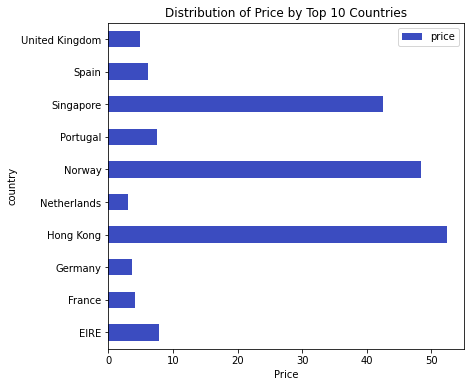

In [21]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)
plt.title('Distribution of Price by Top 10 Countries')
table2 = pd.pivot_table(df_top, index = ['country'], values = 'price')
table2.plot(kind='barh',ax=ax2, colormap="coolwarm")
ax2.set_xlabel("Price");

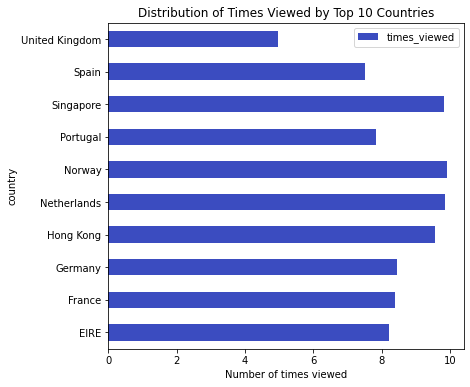

In [22]:
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(121)

plt.title('Distribution of Times Viewed by Top 10 Countries')
table2 = pd.pivot_table(df_top, index = ['country'], values = 'times_viewed')
table2.plot(kind='barh',ax=ax2, colormap="coolwarm")
ax2.set_xlabel("Number of times viewed");

(0.0, 120.0)

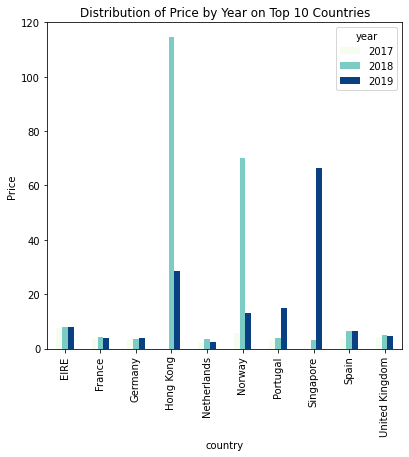

In [23]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

plt.title('Distribution of Price by Year on Top 10 Countries')
table1 = pd.pivot_table(df_top,index='country',columns='year',values="price")
table1.plot(kind='bar',ax=ax1, colormap="GnBu")
ax1.set_ylabel("Price")
ax1.set_ylim((0,120))

(0.0, 12.0)

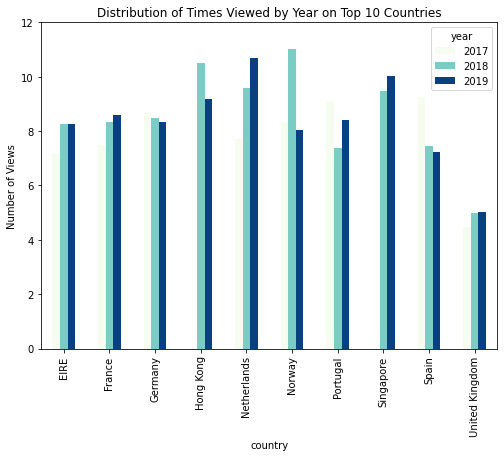

In [24]:
fig = plt.figure(figsize=(18,6))
ax2 = fig.add_subplot(121)

plt.title('Distribution of Times Viewed by Year on Top 10 Countries')
table2 = pd.pivot_table(df_top,index='country',columns='year',values="times_viewed")
table2.plot(kind='bar',ax=ax2, colormap="GnBu")
ax2.set_ylabel("Number of Views")
ax2.set_ylim((0,12))

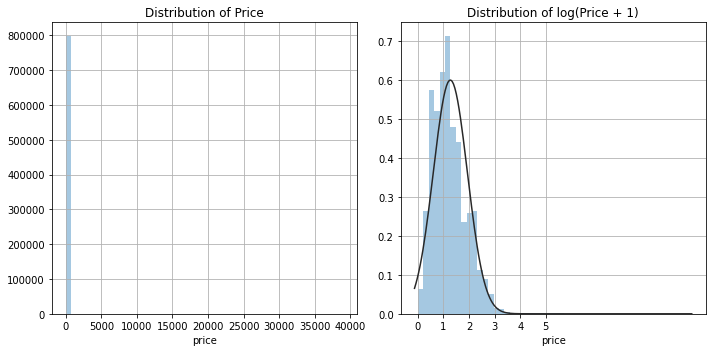

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

#Original Data (High Dispersion)
axes[0].set_title('Distribution of Price')
sns.distplot(df_top.price, ax=axes[0], kde=False)
axes[0].grid()

axes[1].set_title('Distribution of log(Price + 1)')
sns.distplot(np.log1p(df_top.price), ax=axes[1], fit=norm, kde=False)
axes[1].set_xticks(range(0,6))
axes[1].grid()

fig.tight_layout()

In [26]:
#Definindo Feature com transformação logaritimica
df_top['log_price'] = np.log1p(df_top.price)

C:\Users\william_maia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'Distribution of Times Viewed'}, xlabel='times_viewed'>

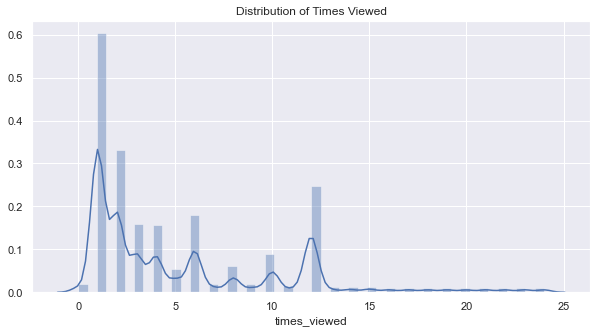

In [27]:
sns.set(rc={"figure.figsize": (10, 5)})
plt.title('Distribution of Times Viewed')
sns.distplot(df_total.times_viewed)

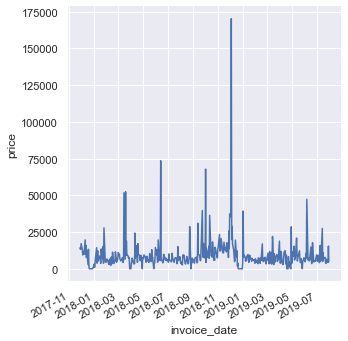

In [31]:
g = sns.relplot(x='invoice_date', y='price', data=df_top.groupby(pd.Grouper(key='invoice_date', freq='B')).sum().reset_index(), kind='line')
g.fig.autofmt_xdate()

In order to carry out a time series analysis, record of each day should be considered and the dataframe should be in a chronological order so that forecasting models can fit and provide revenue i.e price for the following month. Let's start by aggregating the transactions by day

In [32]:
df_agg = df_top.groupby(['invoice_date']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_agg.head(10)

,invoice_date,times_viewed,price,country
0,2017-11-28,14948,14139.140000000087,United Kingdom
1,2017-11-29,14135,13396.920000000135,United Kingdom
2,2017-11-30,15560,13250.070000000167,United Kingdom
3,2017-12-01,12180,9517.350000000051,United Kingdom
4,2017-12-02,3101,1263.2800000000032,United Kingdom
5,2017-12-03,8421,6354.689999999959,Germany
6,2017-12-04,12350,13023.360000000022,United Kingdom
7,2017-12-05,12474,9358.970000000025,United Kingdom
8,2017-12-06,10493,11263.690000000137,United Kingdom
9,2017-12-07,11688,10816.890000000127,United Kingdom


In [30]:
print(df_agg.head(5))
print(df_agg.tail(5))

  invoice_date  times_viewed              price         country
0   2017-11-28         14948 14139.140000000087  United Kingdom
1   2017-11-29         14135 13396.920000000135  United Kingdom
2   2017-11-30         15560 13250.070000000167  United Kingdom
3   2017-12-01         12180  9517.350000000051  United Kingdom
4   2017-12-02          3101 1263.2800000000032  United Kingdom
    invoice_date  times_viewed              price         country
490   2019-07-26          7552 3631.9399999999937  United Kingdom
491   2019-07-28          6227 2862.5400000000013  United Kingdom
492   2019-07-29          6879  4316.049999999987  United Kingdom
493   2019-07-30          6155 15466.779999999932  United Kingdom
494   2019-07-31          9381  4891.479999999984  United Kingdom
